In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7
np.set_printoptions(precision=2, suppress=True)

In [2]:
# HIDDEN
"""
def minimize(cost_fn, grad_cost_fn, X, y, alpha=0.2, progress=True):
    '''
    Uses gradient descent to minimize cost_fn. Returns the minimizing value of
    theta once theta changes less than 0.001 between iterations.
    '''
    theta = np.zeros(X.shape[1])
    old_cost = 10000000
    while True:
        if progress:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        gradient = grad_cost_fn(theta, X, y)
        new_theta = theta - alpha * gradient
        cost = cost_fn(theta, X, y)
        if abs(old_cost - cost) < 10:
            return new_theta
        old_cost = cost
        
        theta = new_theta
        
"""
        
from scipy.optimize import minimize as sci_min

def minimize(cost_fn, grad_cost_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize cost_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return cost_fn(theta, X, y)
    def gradient(theta):
        return grad_cost_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

## Linear Regression Case Study

In this section, we perform an end-to-end case study of the application of a linear regression model to a dataset. The dataset we will be working with is a record of various attributes, such as length and girth, of donkeys.

Our task: predict a donkey's weight using linear regression.

## Preliminary Data Overview

We will begin by reading in the dataset and taking a quick peek at its contents.

In [3]:
donkeys = pd.read_csv("donkeys.csv")
donkeys.head()

,BCS,Age,Sex,...,Height,Weight,WeightAlt
0,3.0,<2,stallion,...,90,77,NaN
1,2.5,<2,stallion,...,94,100,NaN
2,1.5,<2,stallion,...,95,74,NaN
3,3.0,<2,female,...,96,116,NaN
4,2.5,<2,female,...,91,91,NaN


Now, we will look at how large our dataset is.

It's always a good idea to look at _how much_ data we have by looking at the dimensions of the dataset. An example of how this might be useful: if our data has a large number of observations, it would not be a good idea to print out the whole dataframe.

In [4]:
donkeys.shape

(544, 8)

The dataset is relatively small, with only 544 rows of observations and 8 columns. Let's look at what columns we have available to us.

In [5]:
donkeys.columns.values

array(['BCS', 'Age', 'Sex', 'Length', 'Girth', 'Height', 'Weight',
       'WeightAlt'], dtype=object)

Our analysis can be guided by a good understanding of our data, so we should aim to understand what each of these columns represent. A few of these columns are self-explanatory, but others require a little more explanation:

- `BCS`: Body Condition Score 
- `Girth`: the measurement around the middle of the donkey
- `WeightAlt`: 31 donkeys within our data frame were weighed twice in order to check the accuracy of the scale. The second weighing is in `WeightAlt`.


## Data Cleaning

In this section, we will check the data for any abnormalities that we have to deal with.

By examining `WeightAlt` more closely, we can make sure that the scale is accurate by taking the difference between the two different weighings and plotting them.

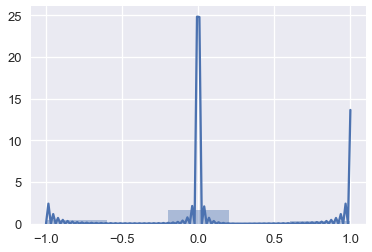

In [6]:
difference = donkeys['WeightAlt'] - donkeys['Weight']
sns.distplot(difference.dropna());

The measurements are all within 1 kg of each other, which seems reasonable.

Next, we can look for unusual values that might indicate errors or other problems. We can use the quantile function in order to detect anomalous values.

In [7]:
donkeys.quantile([0.005, 0.995])

,BCS,Length,Girth,Height,Weight,WeightAlt
0.005,1.5,71.145,90.000,89.0,71.715,98.75
0.995,4.0,111.000,131.285,112.0,214.000,192.80


For each of these numerical columns, we can look at which rows fall outside of these quantiles and what values they take on. Consider that we want our model to apply to only healthy and mature donkeys.

In [8]:
donkeys[(donkeys['BCS'] < 1.5) | (donkeys['BCS'] > 4)]['BCS']

291    4.5
445    1.0
Name: BCS, dtype: float64

Considering that `BCS` is an indication of the health of a donkey, a `BCS` of 1 represents an extremely emaciated donkey and a `BCS` of 4.5 an overweight donkey. Thus, it would probably be a good idea to remove these two donkeys.

---

In [9]:
donkeys[(donkeys['Length'] < 71.145) | (donkeys['Length'] > 111)]['Length']

8       46
22      68
26      69
216    112
Name: Length, dtype: int64

In [10]:
donkeys[(donkeys['Girth'] < 90) | (donkeys['Girth'] > 131.285)]['Girth']

8       66
239    132
283    134
523    134
Name: Girth, dtype: int64

In [11]:
donkeys[(donkeys['Height'] < 89) | (donkeys['Height'] > 112)]['Height']

8       71
22      86
244    113
523    116
Name: Height, dtype: int64

For `Girth`, `Height`, and `Length`, the donkey in row 8 seems to have a much smaller value than the cut-off while the other anomalous donkeys are close to the cut-off and likely do not need to be removed.

---

In [12]:
donkeys[(donkeys['Weight'] < 71.715) | (donkeys['Weight'] > 214)]['Weight']

8       27
26      65
50      71
291    227
523    230
Name: Weight, dtype: int64

The first 2 and last 2 donkeys in the list are far off from the cut-off and most likely should be removed. The middle donkey can be included.

---

Since `WeightAlt` closely corresponds to `Weight`, we do not have to check this column for anomalies. Summarizing what we have learned, here is how we want to filter our donkeys:

- Keep donkeys with `BCS` in the range 1.5 and 4
- Keep donkeys with `Weight` between 71 and 214  


In [13]:
donkeys_c = donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4) &
                         (donkeys['Weight'] >= 71) & (donkeys['Weight'] <= 214)]

## Exploring the Data + Data Visualization

As in any data science project, we will explore our data before attempting to fit a model to it.

First, we will examine the categorical variables with boxplots.

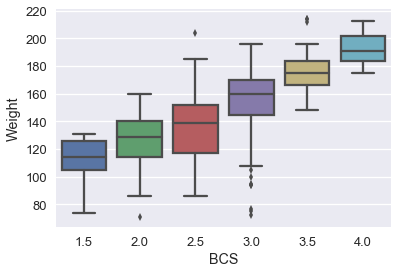

In [14]:
# HIDDEN
sns.boxplot(x=donkeys_c['BCS'], y=donkeys_c['Weight']);

It seems like median weight increases with BCS, but not linearly.

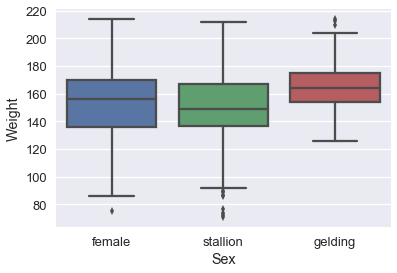

In [15]:
# HIDDEN
sns.boxplot(x=donkeys_c['Sex'], y=donkeys_c['Weight'],
            order = ['female', 'stallion', 'gelding']);

It seems like the sex of the donkey doesn't appear to cause much of a difference in weight.

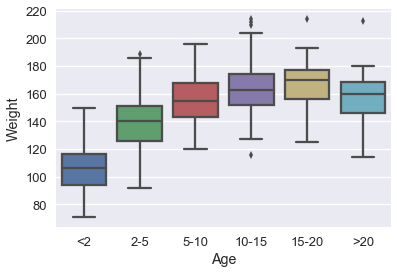

In [16]:
# HIDDEN
sns.boxplot(x=donkeys_c['Age'], y=donkeys_c['Weight'], 
            order = ['<2', '2-5', '5-10', '10-15', '15-20', '>20']);

For donkeys over 5, the weight distribution is not too different.

Now, let's look at the quantitative variables. We can plot each of them against the target variable.

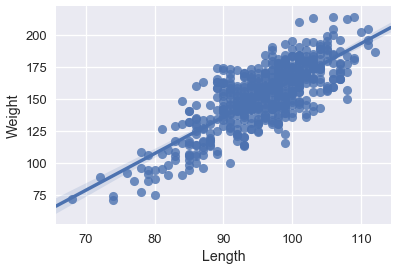

In [17]:
# HIDDEN
sns.regplot('Length', 'Weight', donkeys_c);

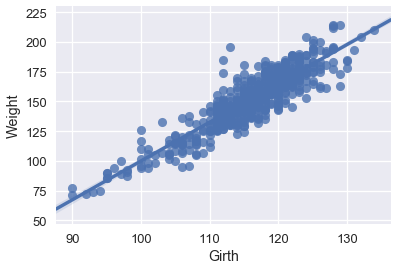

In [18]:
# HIDDEN
sns.regplot('Girth', 'Weight', donkeys_c);

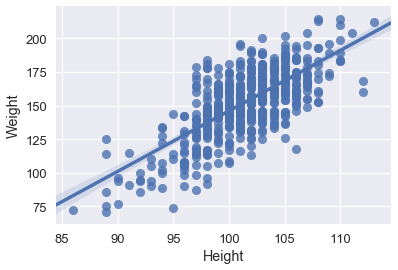

In [19]:
# HIDDEN
sns.regplot('Height', 'Weight', donkeys_c);

All three of our quantitative features have a linear relationship with our target variable of `Weight`, so we will not have to perform any transformations on our input data.

It is also a good idea to see if our features are linear with each other. We plot two below: 

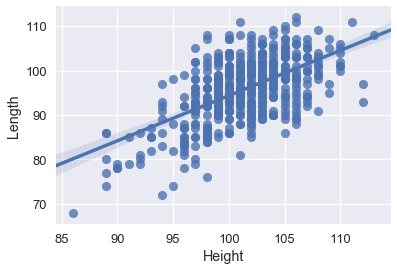

In [20]:
# HIDDEN
sns.regplot('Height', 'Length', donkeys_c);

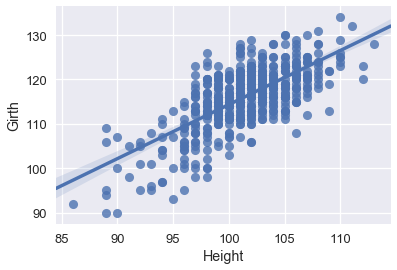

In [21]:
# HIDDEN
sns.regplot('Height', 'Girth', donkeys_c);

From these plots, we can see that our predictor variables also have strong linear relationships with each other. This makes our model harder to interpret, so we should keep this in mind after we create our model.

## Transforming Variables

Next, we transform the categorical variables into dummy variables so that we can include them in the model. Recall from our boxplots that `Sex` was not a useful variable, so we will drop it. We will also remove the `WeightAlt` column because we only have its value for 31 donkeys.

In [22]:
donkeys_c = donkeys_c.drop(['Sex', 'WeightAlt'], axis=1)
donkeys_c = pd.get_dummies(donkeys_c, columns=['BCS', 'Age'])
donkeys_c.head()

,Length,Girth,Height,...,Age_5-10,Age_<2,Age_>20
0,78,90,90,...,0,1,0
1,91,97,94,...,0,1,0
2,74,93,95,...,0,1,0
3,87,109,96,...,0,1,0
4,79,98,91,...,0,1,0


Since we do not want our matrix to be over-parameterized, we should drop one category from the `BCS` and `Age` dummies.

In [23]:
donkeys_c = donkeys_c.drop(['BCS_3.0', 'Age_5-10'], axis=1)
donkeys_c.head()

,Length,Girth,Height,...,Age_2-5,Age_<2,Age_>20
0,78,90,90,...,0,1,0
1,91,97,94,...,0,1,0
2,74,93,95,...,0,1,0
3,87,109,96,...,0,1,0
4,79,98,91,...,0,1,0


We should also add a column of biases.

In [24]:
donkeys_c = donkeys_c.assign(bias=1)

In [25]:
# HIDDEN
donkeys_c = donkeys_c.reindex_axis(['bias'] + list(donkeys_c.columns[:-1]), axis=1)


In [26]:
donkeys_c.head()

,bias,Length,Girth,...,Age_2-5,Age_<2,Age_>20
0,1,78,90,...,0,1,0
1,1,91,97,...,0,1,0
2,1,74,93,...,0,1,0
3,1,87,109,...,0,1,0
4,1,79,98,...,0,1,0


## Linear Regression Model

We are finally ready to fit our model!

Our model looks like this:

$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} (Length) + \hat{\theta_2} (Girth) + \hat{\theta_3} (Height) + ... +  \hat{\theta_{14}} (Age_>20)
$$

Remember, the $\hat{\theta_0}$ is accounted for due to the bias column in our dataframe.

Here are the functions we defined earlier in the multiple linear regression section, which we will use again:

In [27]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

def mse_cost(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

def grad_mse_cost(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y  - X.T @ X @ thetas)

In order to use the above functions, we need `X`, and `y`. These can both be obtained from our dataframe. Remember that `X` and `y` have to be numpy matrices in order to be able to multiply them with `@` notation.

`X` consists of all columns of the dataframe except for the target column, `Weight`. 

In [28]:
X = (donkeys_c
     .drop(['Weight'], axis=1)
     .as_matrix())

`y` consists of the `Weight` column of our dataset.

In [29]:
y = donkeys_c['Weight'].as_matrix()

Now we just need to call the `minimize` function defined in a previous section.

In [30]:
thetas = minimize(mse_cost, grad_mse_cost, X, y)

theta: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] | cost: 23830.83
theta: [ 0.01  0.53  0.65  0.56  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.  ] | cost: 1251.65
theta: [-0.07  2.    2.34 -2.78 -0.03 -0.1  -0.33  0.17  0.07  0.32  0.06 -0.19
 -0.31  0.02] | cost: 1038.97
theta: [-0.25 -0.75  5.1  -3.39 -0.09 -0.29 -1.11  0.55  0.26  0.98  0.2  -0.59
 -0.97  0.05] | cost: 882.01
theta: [-0.42 -0.45  4.52 -3.08 -0.14 -0.45 -1.77  0.86  0.43  1.48  0.35 -0.9
 -1.53  0.08] | cost: 600.47
theta: [-1.25  0.49  2.84 -2.14 -0.43 -1.34 -4.54  2.36  1.29  3.36  1.13 -2.13
 -4.34  0.33] | cost: 211.62
theta: [-2.45  0.98  1.76 -1.4  -0.9  -2.75 -7.44  4.27  2.56  5.01  2.25 -3.41
 -8.12  0.84] | cost: 141.47
theta: [ -3.23   0.96   1.61  -1.21  -1.26  -3.77  -8.41   5.27   3.41   5.33
   2.94  -3.9  -10.27   1.26] | cost: 134.37
theta: [ -4.99   0.88   1.41  -0.88  -2.12  -6.14  -9.83   7.27   5.38   5.58
   4.36  -4.81 -14.75   2.19] | cost: 122.79
theta: [ -8.49   0.

Looks like gradient descent converged to those theta values! Thus, our linear model is:

$y = -218.56 + 0.93x_1 + ... -6.36x_{13} + 0.38x_{14}$

Let's compare this equation that we obtained to the one we would get if we had used `sklearn`'s LinearRegression model instead. The LinearRegression model automatically includes a column of all 1's in our data, so we can get rid of our column of 1's when we pass `X` into the `fit` function.

In [31]:
len(donkeys_c.columns.values)

15

In [32]:
model = LinearRegression()
model.fit(X[:, :14], y)
print("Coefficients", model.coef_)
print("Intercept", model.intercept_)

Coefficients [  0.     0.93   1.7    0.85 -11.68  -7.61  -5.96   7.41  13.41   2.04
   2.57  -3.12  -6.36   0.38]
Intercept -218.555096944


The coefficients look pretty similar! Our homemade functions create the same model as an established Python package!

We successfully fit a linear model to our donkey data! Nice!